# Puntaje Bancario: Aprobación de Crédito Mediante Redes Neuronales

En esta ocasión se busca desarrollar un protocolo de pruebas que permita encontrar la mejor arquitectura de red neuronal completamente conectada. En esta ocasión debe utilizar la librería SciKit-Learn (sklearn.neural_network) para diseñar cada red. Además, veremos algunos conceptos de _feature engineering_ para analizar los datos a nuestra disposición.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **18 de octubre** y se realizará a través de Bloque Neón.

In [122]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Se tienen dos archivos:

`application_record.csv`: posee información general (puede observar los nombres de las columnas a continuación) sobre cada usuario, definido a partir de una ID única.

- ID: número de cliente
- CODE_GENDER: género
- FLAG_OWN_CAR:	posee un automóvil
- FLAG_OWN_REALTY: posee un inmueble
- CNT_CHILDREN:	cantidad de hijos
- AMT_INCOME_TOTAL:	ingresos anuales
- NAME_INCOME_TYPE: categoría de ingresos
- NAME_EDUCATION_TYPE: nivel educativo
- NAME_FAMILY_STATUS estado civil
- NAME_HOUSING_TYPE: forma de vivienda (e.g. renta, apartamento propio, ...)
- DAYS_BIRTH: fecha de nacimiento, en días hacia atrás desde la actualidad, -1 significa ayer

- DAYS_EMPLOYED: tiempo de empleo, en días hacia atrás desde la actualidad, -1 significa ayer. Si es positivo, el usuario se encuentra desempleado.
- FLAG_MOBIL: teléfono móvil
- FLAG_WORK_PHONE: teléfono de trabajo
- FLAG_PHONE: teléfono
- FLAG_EMAIL: email
- OCCUPATION_TYPE: ocupación
- CNT_FAM_MEMBERS: tamaño de familia


`credit_record.csv`:

- ID: número de cliente
- MONTHS_BALANCE: mes de registro
- ESTADO:
    - 0: 1-29 días atrasados
    - 1: 30-59 días atrasados
    - 2: 60-89 días atrasados
    - 3: 90-119 días atrasados
    - 4: 120-149 días atrasados
    - 5: Atrasados o incobrables, cancelaciones durante más de 150 días
    - C: cancelado ese mes X: sin préstamo durante el mes

In [123]:

data = pd.read_csv("application_record.csv", encoding = 'utf-8')
record = pd.read_csv("credit_record.csv", encoding = 'utf-8')




In [124]:
plt.rcParams['figure.facecolor'] = 'white'

In [125]:
data.tail()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0
438556,6842885,F,N,Y,0,121500.0,Working,Secondary / secondary special,Married,House / apartment,-18858,-1201,1,0,1,0,Sales staff,2.0


In [126]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Preparación de los Datos

### Etiquetas

Inicialmente, se concatenan ambas tablas mediante el tiempo de registro máximo (`MONTHS_BALANCE`) y la ID del cliente.

In [127]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min)) #de record copia la columna "ID" y "MONTHS_BALANCE"
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) # se remplaza  "MONTHS_BALANCE" por 'begin_month'
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data   #se concate en data, en la última columna ''begin_month'

Los usuarios con mora durante más de 60 días se etiquerarán como `1`, de lo contrario, serán `0`.

In [128]:
record['dep_value'] = None  #Se agrega una columna a record si'status' es mayor de dos meses se asigna un 'yes', caso contrario in 'none'
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [129]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [130]:
print(cpunt['dep_value'].value_counts()) #Acá se puede ver la matriz desbalanceada hay 45318 No, Yes 667
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

Proporción de clases.

### Descriptores

+ Renombramiento de las Columnas

In [131]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality', #hay tres columna add:'begin_month', 'dep_value','target'
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [132]:
new_data.tail()

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1
36456,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-13.0,Yes,1


In [133]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna() # Retiramos los valores NaN

In [134]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

### Funciones Auxiliares

A continuación se crean algunas funciones que serán utilizadas más adelante.

Función `calc_iv` para obtener las variables IV (information value) y WoE (weight of evidence). Estas variables, de forma general, nos permiten conocer la importancia de cada feature disponible.

Puede encontrar más información en:
- https://www.kaggle.com/puremath86/iv-woe-starter-for-python
- https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [135]:
# Cálculo de IV
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

In [136]:
# Codificación One-Hot
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [137]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [138]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

### Descriptores Binarios

Se utilizará la función desarrollada anteriormente para realizar un análisis de cada uno de los descriptores binarios y **su influencia dentro de la predicción de cada clase**.

#### Género

In [139]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
El IV de esta variable es: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


Análisis de resultados
Gender (F)

Si WoE es positivo es porque Distribution Good > Distibution bad .WOE 0.1340.
IV=0.010473, Se observa que para valores de less 0.02 La variable de predicción no es buena para separar GOODS from BADS

Gender (M)

Woe es negativo porque Distribution Good < Distribution Bad, WoE=-0.188475 .
IV=0.014730. Se observa que para valores de less 0.02 La variable de predicción no es buena para separar GOODS from BADS


#### Posesión de un Automóvil

In [140]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
El IV de esta variable es: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


Posesión de un automóvil

0=No, IV less 0.02 No es una buena variable de predicción.
1=YES, IV less 0.02 No es una buena variable de predicción.


#### Posesión de un Inmueble

In [141]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64
El IV de esta variable es: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


IV es less 0.02 no es una variable de predicción buena.

#### Posesión de un Teléfono

In [142]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

1    0.292791
0    0.707209
Name: phone, dtype: float64
El IV de esta variable es: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


IV es less 0.02 no es una variable de predicción buena.

#### Posesión de Correo Electrónico (Email)

In [143]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
El IV de esta variable es: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


IV es less 0.02 no es una variable de predicción buena.

#### Posesión de Teléfono para Trabajo

In [144]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

El IV de esta variable es: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


IV es less 0.02 no es una variable de predicción buena.

### Descriptores Continuos

#### Cantidad de Hijos

In [145]:
# Separamos aquellos que: no tienen hijos, tienen 1 hijo, tienen 2 o más hijos.
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


In [146]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

El IV de esta variable es: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


Análisis, Como es una variable continua se debe dividir primero, se dividio en 3.

IV es less 0.02 no es una variable de predicción buena.

In [147]:
new_data = convert_dummy(new_data,'ChldNo') # Adicionamos una Codificación One-Hot 

In [148]:
new_data.head()

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0,0,0
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0,0,0
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
5,5008810,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
6,5008811,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0,0,0


#### Ingresos Anuales

Gráfica de Histograma para observar la distribución.

In [149]:
new_data['inc'] = new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


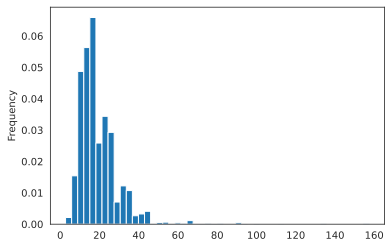

In [150]:
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [151]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

El IV de esta variable es: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


IV es less 0.02 no es una variable de predicción buena.

In [152]:
new_data = convert_dummy(new_data,'gp_inc')

#### Edad

In [153]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


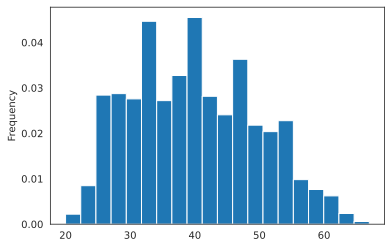

In [154]:
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [155]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

El IV de esta variable es: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


IV Value Highes= 0.04399, tiene una debil predicción, pero es mejor que los demas grupos de edad,  se puede ver que el rango mas alto de edad tiende a tener buenos pronósticos bancários, Además se puede corroborrar con los Good=989 vs Bads=4

In [156]:
new_data = convert_dummy(new_data,'gp_Age')

In [157]:
new_data.head()

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More,gp_inc_high,gp_inc_medium,Age,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest
2,5008806,1,1,1,11.25,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0,0,0,0,0,58,0,1,0,0
3,5008808,0,0,1,27,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0,0,0,1,0,52,1,0,0,0
4,5008809,0,0,1,27,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0,1,0,52,1,0,0,0
5,5008810,0,0,1,27,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0,1,0,52,1,0,0,0
6,5008811,0,0,1,27,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0,0,0,1,0,52,1,0,0,0


#### Años de Trabajo

In [158]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean

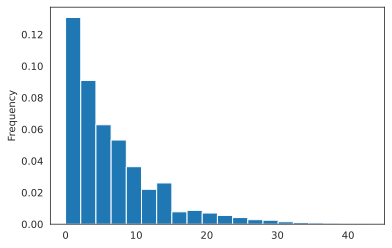

In [159]:
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [160]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

El IV de esta variable es: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [161]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'gp_worktm')

#### Tamaño de Familia

In [162]:
new_data['famsize'].value_counts(sort=False)

2.0     12697
1.0      4263
3.0      5216
4.0      2576
6.0        51
9.0         2
5.0       307
7.0        18
20.0        1
15.0        3
Name: famsize, dtype: int64

In [163]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

El IV de esta variable es: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [164]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'famsizegp')

### Descriptores Categóricos

#### Forma de Ingresos

In [165]:
new_data

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More,gp_inc_high,gp_inc_medium,Age,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,worktm,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,famsizegp_1,famsizegp_3more
2,5008806.0,1.0,1.0,1.0,11.25,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0,0,0,Security staff,2,-29.0,No,0,0.0,0.0,0.0,0.0,58.0,0.0,1.0,0.0,0.0,3.0,0,0,0,0,0,0
3,5008808.0,0.0,0.0,1.0,27,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0,1,1,Sales staff,1,-4.0,No,0,0.0,0.0,1.0,0.0,52.0,1.0,0.0,0.0,0.0,8.0,0,0,0,0,1,0
4,5008809.0,0.0,0.0,1.0,27,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0,1,1,Sales staff,1,-26.0,No,0,0.0,0.0,1.0,0.0,52.0,1.0,0.0,0.0,0.0,8.0,0,0,0,0,1,0
5,5008810.0,0.0,0.0,1.0,27,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0,1,1,Sales staff,1,-26.0,No,0,0.0,0.0,1.0,0.0,52.0,1.0,0.0,0.0,0.0,8.0,0,0,0,0,1,0
6,5008811.0,0.0,0.0,1.0,27,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0,1,1,Sales staff,1,-38.0,No,0,0.0,0.0,1.0,0.0,52.0,1.0,0.0,0.0,0.0,8.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828.0,1.0,1.0,1.0,31.5,Working,Secondary / secondary special,Married,House / apartment,-17348.0,-2420.0,1.0,0,0,0,Managers,2,-11.0,Yes,1,0.0,0.0,1.0,0.0,47.0,0.0,0.0,0.0,0.0,6.0,0,0,0,0,0,0
36453,5149834.0,0.0,0.0,1.0,15.75,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0,1,1,Medicine staff,2,-23.0,Yes,1,0.0,0.0,0.0,1.0,33.0,0.0,0.0,1.0,0.0,3.0,0,0,0,0,0,0
36454,5149838.0,0.0,0.0,1.0,15.75,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0,1,1,Medicine staff,2,-32.0,Yes,1,0.0,0.0,0.0,1.0,33.0,0.0,0.0,1.0,0.0,3.0,0,0,0,0,0,0
36455,5150049.0,0.0,0.0,1.0,28.35,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0,0,0,Sales staff,2,-9.0,Yes,1,0.0,0.0,1.0,0.0,49.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0


In [166]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Student                    10
Working                 15622
Pensioner                  13
State servant            2437
Commercial associate     7052
Name: inctp, dtype: int64
Student                 0.000398
Working                 0.621549
Pensioner               0.000517
State servant           0.096960
Commercial associate    0.280576
Name: inctp, dtype: float64
El IV de esta variable es: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [167]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'inctp')

#### Tipo de Ocupación

In [168]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
El IV de esta variable es: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [169]:
new_data = convert_dummy(new_data,'occyp')

In [170]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'houtp',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone',
       'email', 'famsize', 'begin_month', 'dep_value', 'target', 'ChldNo_1',
       'ChldNo_2More', 'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'worktm',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk'],
      dtype='object')

#### Forma de Vivienda

In [171]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

El IV de esta variable es: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [172]:
new_data = convert_dummy(new_data,'houtp')

In [173]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents'],
      dtype='object')

#### Educación

In [174]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

El IV de esta variable es: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [175]:
new_data = convert_dummy(new_data,'edutp')

In [176]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents',
       'edutp_Higher education', 'edutp_Incomplete higher',
       'edutp_Lower secondary'],
      dtype='object')

####  Estado Civil

In [177]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Civil marriage          0.084865
Separated               0.058367
Married                 0.696626
Widow                   0.023076
Single / not married    0.137065
Name: famtp, dtype: float64

In [178]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

El IV de esta variable es: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [179]:
new_data = convert_dummy(new_data,'famtp')

In [180]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

## Utilidad de: IV y WoE

Puede leer el artículo a continuación para comprender un poco más sobre los conceptos de IV y WoE:

https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-07A78308-525A-406F-8221-9281F4E9D7CF.html

La tabla a continuación fue tomada de la referencia indicada:

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Bajo poder predictivo | 
|0.02~0.1 |Poder predictivo débil|
|0.1~0.3|Poder predictivo moderado|
|0.3~0.5|Poder predictivo fuerte|
|>0.5|Sospechosamente alto, revisar esta variable| 

In [181]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0659351
8,famtp,0.0431371
11,worktmgp,0.0402215
3,Reality,0.0274407
1,Gender,0.0252035
7,edutp,0.0103618
9,houtp,0.0073275
17,famsize,0.00615614
16,occyp,0.00482047
5,incgp,0.002422


# Predicción de Buen/Mal Cliente Mediante Redes Neuronales

+ Split Dataset

In [182]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

Se tomarán únicamente aquellas columnas preprocesadas y con un $IV>0.001$

In [183]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
              'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
              'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
              'houtp_Co-op apartment', 'houtp_Municipal apartment',
              'houtp_Office apartment', 'houtp_Rented apartment',
              'houtp_With parents','edutp_Higher education',
              'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
              'famtp_Separated','famtp_Single / not married','famtp_Widow']]

### SMOTE

Concepto: Synthetic Minority Over-Sampling Technique(`SMOTE`) utilizado para lidiar con datos desbalanceados. Puede encontrar más información en:

- http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [184]:
Y = Y.astype('int')
sm = SMOTE()
X_balance,Y_balance = sm.fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

## Análisis SMOTE. The Synthetic Minority Oversampling Technique
El balanceo de datos es un punto clave e indispensable, porque si está desbalanceada va a generar un mal desempeño sobre la clase más pequeña, y la clase más pequeña generalmente es más importante a clasificar. La técnica que se usa es sobremuestrear la clase minoritaria, estos datos no agregan nueva información al modelo, en cambio sintetiza nuevos ejemplos a partir de los existentes. 

Separación de datos en conjuntos: entrenamiento y prueba. 70 % datos de entrenamiento , 30 % datos de prueba

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

# \*Seleccione esta celda y luego la opción `Run All Above`\*

# PARTE 1

## Separación de Conjunto de Features

Teniendo en cuenta los resultados de IV obtenidos anteriormente, comprobaremos la capacidad predictiva de tres conjuntos de datos basados en la tabla anterior. Primero removeremos los últimos cuatro ('phone', 'inctp', 'email', 'Car'), y luego realizaremos la siguiente división:

- A. Primera mitad: 'agegp', 'famtp', 'worktmgp', 'Reality', 'Gender', 'edutp'
- B. Segunda mitad: 'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'
- C. Todos los descriptores.

De acuerdo a estos nombres, utilice la siguiente lista para identificar aquellos solicitados en cada caso:
```
    'Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
    'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
    'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
    'occyp_officewk','famsizegp_1', 'famsizegp_3more',
    'houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow'
```
### A. Top 6. se seleccionó 6 features del grupo A

In [186]:

X_train_subA = X_train[[ 'edutp_Lower secondary','edutp_Incomplete higher','edutp_Higher education','Gender','gp_Age_high','gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest','famtp_Widow','famtp_Single / not married','famtp_Separated','famtp_Civil marriage','gp_worktm_high', 'gp_worktm_high','gp_worktm_low', 'gp_worktm_medium','Reality']]



X_test_subA = X_test[[ 'edutp_Lower secondary','edutp_Incomplete higher','edutp_Higher education','Gender','gp_Age_high','gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest','famtp_Widow','famtp_Single / not married','famtp_Separated','famtp_Civil marriage','gp_worktm_high', 'gp_worktm_high','gp_worktm_low', 'gp_worktm_medium','Reality']]

X_train_subA.head()

,edutp_Lower secondary,edutp_Incomplete higher,edutp_Higher education,Gender,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,famtp_Widow,famtp_Single / not married,famtp_Separated,famtp_Civil marriage,gp_worktm_high,gp_worktm_high,gp_worktm_low,gp_worktm_medium,Reality
32515,0.0,0.0,0.0,1.0,0.0,0.0,0.786358,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.213642,0.0
14471,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
16400,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0
29956,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0
39904,0.0,0.0,1.0,0.0,0.0,0.0,0.936987,0.063013,0.0,0.0,0.0,0.0,0.0,0.0,0.936987,0.000000,0.0


### B. Últimos 6

In [187]:
X_train_subB = X_train[['houtp_Co-op apartment','houtp_Municipal apartment','houtp_Office apartment', 'houtp_Rented apartment','houtp_With parents','famsizegp_1', 'famsizegp_3more','occyp_hightecwk', 
    'occyp_officewk','gp_inc_medium',  'gp_inc_high','wkphone','ChldNo_1', 'ChldNo_2More' ]]

X_test_subB = X_test[['houtp_Co-op apartment','houtp_Municipal apartment','houtp_Office apartment', 'houtp_Rented apartment','houtp_With parents','famsizegp_1', 'famsizegp_3more','occyp_hightecwk', 
    'occyp_officewk', 'gp_inc_medium',  'gp_inc_high','wkphone','ChldNo_1', 'ChldNo_2More']]

X_train_subB.head()

,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,famsizegp_1,famsizegp_3more,occyp_hightecwk,occyp_officewk,gp_inc_medium,gp_inc_high,wkphone,ChldNo_1,ChldNo_2More
32515,0.0,1.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.213642,0.786358,0.0,0.0,1.0,0.0
14471,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0
16400,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0
29956,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.821401,0.000000,0.0,0.0,0.0,1.0
39904,0.0,0.0,0.0,0.063013,0.0,0.0,1.0,0.0,0.000000,1.000000,0.0,0.0,1.0,0.0


## Caso C

Acá simplemente tomaremos, no es necesario crear nuevas variables:
```
X_train_subC = X_train
X_test_subC = X_test
```

In [188]:
X_train_subC = X_train
X_test_subC = X_test

## Análisis y Conclusiones Parte 1




1. Caso A: 'agegp', 'famtp', 'worktmgp', 'Reality', 'Gender', 'edutp'   

*   'agegp'   IV =0.0659351
*   'famtp'   IV = 0.04313 
*   'worktmgp'IV = 0.04022
*   'Reality' IV = 0.02744
*   'Gender'  IV =0.0252035
*   'edutp'   IV =0.01036 

2.   Caso B:  'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'


*   'houtp'     IV = 0.00732
*   'famsize'   IV = 0.00615 
*   'occyp'     IV = 0.00482
*   'incgp'     IV = 0.00242
*   'wkphone'   IV = 0.00204
*   'ChldNo'    IV = 0.00112


El valor de IV (Information Value), es la técnica más utilizada para seleccionar variables en un modelo de predicción y ranquea las variables desde las básicas hasta las más importantes.

IV esta definido por :Sumatoria(% de no enventos- % de no enventos )*WOE

WOE= ln (%Distribución de 'Goods'/ % Distribución de 'Bads')

Se cuenta con una tabla de indicación de IV si es una buena variable de predicción:



*   Menos de 0.02, el predictor no es bueno para separar 'GOODS' vs 'BADS'
*   0.02 a 0.1, débil predicción 
*   0.1 a 0.3 predictor medio
*   0.3 a 0.5 fuerte predictor
*  Mayor que 0.5, sospechoso volverlo a medir

Observando los valores indicados, no hay valores IV por encima de 0.1. En el caso A todas las variables de predicción están posicionadas como variables de débil predicción (0.02 a 0.1). El caso A tienen los mejores resultados por ende se supone de antemano antes de ver el resultados del clasificador, se creé
que va a dar una mejor respuesta, más confiabilidad, porque evidencia que estas variables son más importantes. Este problma de red neuronal es bancario y sin ser una experta en el tema se puede inferir que variables como: la edad, estado civil, género, tiempo de empleado, variables del caso A se consideran de más peso ya que tienen más poder adquisitivo. En caso contrario el caso B los valores IV se encunentran en menores a 0.02, por tanto estas variables no van a ser una predicción confiable.

En el caso C, como se encuentran todas las variables, va a  ser el clasificador mas confiable, pero debemos anotar que una variable importante en casos de machine learning es la carga computacional, por tal motivo si hay muchos datos y la carga computacional es muy pesada es conveniente realizar el entrenamiento con las variables más importantes que se encuentran en el caso A.



---




# PARTE 2

Implementación de pruebas en los conjuntos de descriptores. A continuación debe implementar, inicialmente tres modelos de regresión logística, y posteriormente tres redes neuronales (2 capas escondidas, 20 neuronas en cada una). Observe los resultados y analice lo sucedido. Concluya sobre qué modelo es deseable teniendo en cuenta la factibilidad de implementación práctica y la matriz de confusión correspondiente.

## Regresión Logística

Inicialmente se probará un modelo de regresión logística para tener una referencia (también se conoce como _baseline_) y comprobar que un modelo de red neuronal permite obtener mejores resultados.

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

### Caso A

Precisión 0.59125
      0     1
0  3977  3437
1  2624  4790
[[3977 3437]
 [2624 4790]]


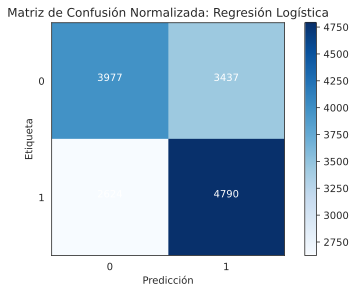

In [189]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subA,y_train) # Ajuste el modelo con los datos del conjunto A # Con los datos de y_train, 

y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')

In [190]:
y_test.size

14828

## Análisis modelo Caso A.

El la evaluación del clasificador baseline l Caso A, arrojó los siguientes resultados:



*   El total de datos de Prueba: 14828.
*   La precisión es de 0.591
*   Matriz de confusión:
        1.   TN(True negative)=3864
        2.   TP(True positive)=4908 
        3.   FP(False Positive)= 3550   (Datos en clase 1, pero son clase cero)
        4.   FN(False Negative)= 2506  (Datos en clase cero, pero son clase uno)

Podemos inferir de la matriz de confusión que 3864 (TN)+ 4908(TP)= 8772 datos bien clasificados.Los datos que nos debería preocupar son FP=3550 y FN= 2506 que da un total de FP+FN= 3550 +  2506= 6056 datos mal clasificados que corresponden a 40.84165 % de los datos los datos totales.
También lo corrobora el dato de precisión  0.591, que es la fracción de todas instancias donde la predicción del clasificador es correcta, para cualquier positiva o negativa clase.
En conclusión no es un buen resultado y el banco puede generar pérdidas supongo que en los datos mal clasificados le puede dar un préstamo a un usuario que a futuro no lo va a poder pagar. 



  





## Caso B

Precisión 0.52644
      0     1
0  3945  3469
1  3553  3861
[[3945 3469]
 [3553 3861]]


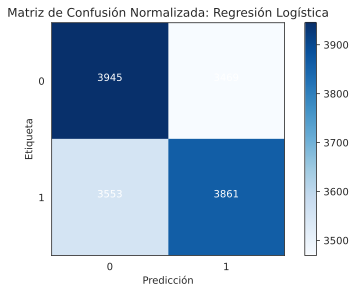

In [193]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subB,y_train) # Ajuste el modelo con los datos del conjunto B #
y_predict = model.predict( X_test_subB ) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


Análisis Caso B
Acpa ocurre un resultado de la matriz distinto al del caso A; En este grupo de datos no clasificada bien los datos con etiqueta cero,  El valor de TN 1490 equivale a 20.09% muy bajo por eso es que se tiene alto el FP=5924 (79.9). 


## Análisis modelo Caso B

El la evaluación del clasificador baseline l Caso A, arrojó los siguientes resultados:



*   El total de datos de Prueba: 14828.
*   La precisión es de: 0.53372
*   Matriz de confusión: 
        1.   TN(True negative)=3913
        2.   TP(True positive)=4001 
        3.   FP(False Positive)=3501   (Datos en clase 1, pero son clase cero)
        4.   FN(False Negative)= 3413  (Datos en clase cero, pero son clase uno)

Podemos inferir de la matriz de confusión que 3913 (TN)+ 4001(TP)= 7914 datos bien clasificados.Los datos que nos debería preocupar son FP=3501 y FN= 3413 que da un total de FP+FN= 3501 + 3413= 6914 mal clasificados

La precisión es de 0.533, no es muy bueno.


```
# Tiene formato de código
```



## Caso C

Precisión 0.60049
      0     1
0  3993  3421
1  2503  4911
[[3993 3421]
 [2503 4911]]


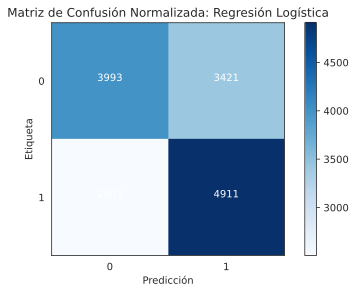

In [194]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subC,y_train) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict(X_test_subC) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


## Red Neuronal, Perceptrón Multicapa

Ahora utilice la función `MLPClassifier` de la librería SciKit-Learn para desarrollar una red neuronal que permita mejorar el rendimiento del clasificador _baseline_ desarrollado.

### Caso A

Precisión 0.82796
      0     1
0  6344  1070
1  1481  5933
[[6344 1070]
 [1481 5933]]


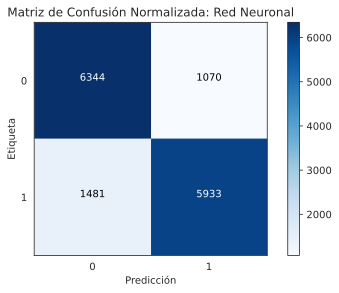

In [195]:
from sklearn.neural_network import MLPClassifier


model = MLPClassifier(hidden_layer_sizes=[20 , 20], activation='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subA, y_train) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso B

Precisión 0.77367
      0     1
0  5687  1727
1  1629  5785
[[5687 1727]
 [1629 5785]]


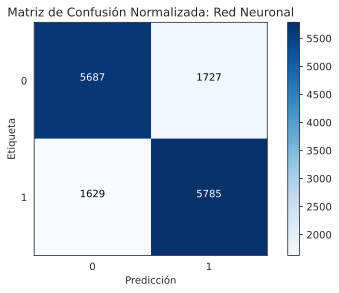

In [196]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=[20 , 20], activation='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subB,y_train) # Ajuste el modelo con los datos del conjunto B #
y_predict = model.predict(X_test_subB) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso C

Precisión 0.94794
      0     1
0  6928   486
1   286  7128
[[6928  486]
 [ 286 7128]]


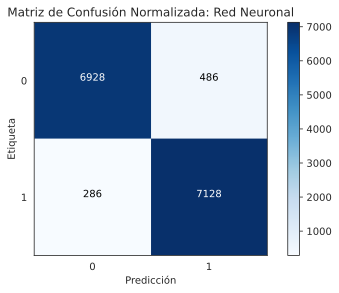

In [197]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier( hidden_layer_sizes=[20 , 20], activation='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subC,y_train  ) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict( X_test_subC ) # Realice la predicción de etiquetas con los datos de prueba del conjunto Cmm #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

## Conclusiones Parte 2
Cuadros comparativos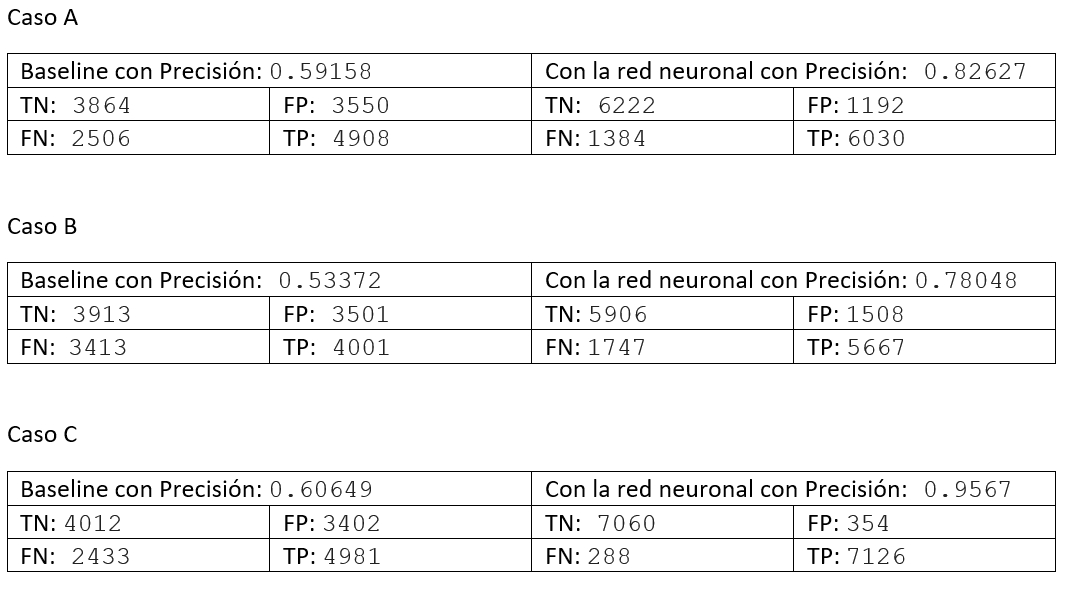



*   El clasificador con menos eficiencia es el caso B donde se tienen las variables predictoras que no tienen tanto peso, se puede ver esto los valores de IV. Le sigue el clasificador caso A, que sus datos de entrenamiento la componen las variables de más importancia (Datos más altos de IV) y por último el mejor es el caso donde se tienen las variables se suponía de antemano que iba a ser el mejor. También podemos inferir que en problemas de machine learning la carga computacional es una medida que se debe tener en cuenta, entonces si hay una carga computacional muy grande yo escogería el caso A.

* Caso A con baseline vs red neuronal. La red permite el mejoramiento de la baseline. La precisión subió 23.46% es un salto de eficiencia grandísimo. Tener una precisión en 82.62 es un clasificador muy bueno.   



*	Caso B con baseline vs red neuronal. La precisión subió 24.67%, subió un puntico de porcentaje más que el caso A, pero de todas maneras la precisión es de 78.04 por debajo del caso A.

*	Caso C con baseline vs red neuronal. La precisión subió 35.02 %, es el mejor de todos. 

* Conclusión final: Utilizar la red neuronal mejora muchísimo un clasificador de regresión logística. Un dato para añadir en la teoría evidencian que el IV es un valor de información diseñado mas que todo en casos de ‘Binary Logistic Regression’ como es este caso.



# PARTE 3

Los resultados obtenidos para las redes neuronales anteriores únicamente corresponden a una arquitectura. Un proceso necesario e importante en casos de estudio como este es la búsqueda de hiperparámetros, en este caso, el número de neuronas más adecuado (al menos dentro de cierto rango, este proceso también se conoce como [GridSearch](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)).

**Divida el conjunto de datos de prueba en dos mitades: datos de validación y datos de prueba. Utilice los datos de validación para realizar una evaluación preliminar de cada modelo.** Utilice `train_test_split` para esta parte.

Utilice todos los descriptores para esta prueba y realice las siguientes búsquedas:

- Caso A: 1 capa escondida $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso B: 2 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso C: 3 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.

Utilice `matplotlib.pyplot` para graficar la precisión en los datos de validación, seleccione el mejor modelo, y obtenga una evaluación final para esta selección utilizando los datos de prueba.

### Caso A

5
Precisión con 5 neuronas y una capa escondida 0.71325 
      0     1
0  2386  1323
1   803  2902
10
Precisión con 10 neuronas y una capa escondida 0.78514 
      0     1
0  2736   973
1   620  3085
20
Precisión con 20 neuronas y una capa escondida 0.82236 
      0     1
0  2939   770
1   547  3158
50
Precisión con 50 neuronas y una capa escondida 0.90167 
      0     1
0  3266   443
1   286  3419
100
Precisión con 100 neuronas y una capa escondida 0.93674 
      0     1
0  3399   310
1   159  3546


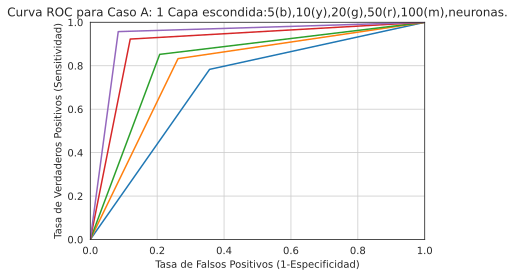

In [198]:
# # # # Implemente un ciclo FOR para entrenar cada una de las configuraciones solicitadas # # # #
# 1. División datos de prueba

#x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.5,random_state=20)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve


X_valid, X_test2, y_valid, y_test2 = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

neuronas=[5,10,20,50,100]
#neurona=0


for i in neuronas:
    model = MLPClassifier( hidden_layer_sizes=[i], activation='relu') ##
    model.fit(X_valid,y_valid) # Acá se entrena con los datos de validación #
    y_predict = model.predict(X_test2) #Acá y_predict se evalua con los datos test_2#
    print (i)
    print(f'Precisión con {round(i,5)} neuronas y una capa escondida {round(accuracy_score(y_test2, y_predict),5)} ')
    print(pd.DataFrame(confusion_matrix(y_test2,y_predict)))
    # Grafica ROC
    fpr, tpr, thresholds = roc_curve(y_test2,y_predict)
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Curva ROC para Caso A: 1 Capa escondida:5(b),10(y),20(g),50(r),100(m),neuronas.')
    plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
    plt.grid(True)





### Caso B

5
Precisión con 5 neuronas y dos capas escondidas 0.73199
      0     1
0  2396  1313
1   674  3031
10
Precisión con 10 neuronas y dos capas escondidas 0.7823
      0     1
0  2774   935
1   679  3026
20
Precisión con 20 neuronas y dos capas escondidas 0.88764
      0     1
0  3137   572
1   261  3444
50
Precisión con 50 neuronas y dos capas escondidas 0.94295
      0     1
0  3380   329
1    94  3611
100
Precisión con 100 neuronas y dos capas escondidas 0.94429
      0     1
0  3482   227
1   186  3519


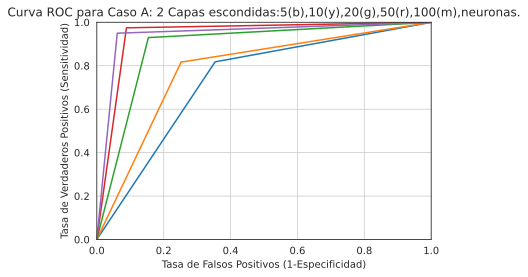

In [199]:
# Caso B: 2 capas escondidas  ×  {5, 10, 20, 50, 100} neuronas #

#import numpy as np
from sklearn.model_selection import train_test_split

X_valid, X_test2, y_valid, y_test2 = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

neuronas=[5,10,20,50,100]
#neurona=0

for i in neuronas:
    model = MLPClassifier( hidden_layer_sizes=[i,i], activation='relu') ##
    model.fit(X_valid,y_valid) # Acá se entrena con los datos de validación #
    y_predict = model.predict(X_test2) #Acá y_predict se evalua con los datos test_2#
    print (i)
    print(f'Precisión con {round(i,5)} neuronas y dos capas escondidas {round(accuracy_score(y_test2, y_predict),5)}')
    print(pd.DataFrame(confusion_matrix(y_test2,y_predict)))
     # Grafica ROC
    fpr, tpr, thresholds = roc_curve(y_test2,y_predict)
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Curva ROC para Caso A: 2 Capas escondidas:5(b),10(y),20(g),50(r),100(m),neuronas.')
    plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
    plt.grid(True)
  
      



### Caso C

5
Precisión con 5 neuronas y tres capas escondidas 0.74427
      0     1
0  2612  1097
1   799  2906
10
Precisión con 10 neuronas y tres capas escondidas 0.80955
      0     1
0  2878   831
1   581  3124
20
Precisión con 20 neuronas y tres capas escondidas 0.91489
      0     1
0  3276   433
1   198  3507
50
Precisión con 50 neuronas y tres capas escondidas 0.94025
      0     1
0  3439   270
1   173  3532
100
Precisión con 100 neuronas y tres capas escondidas 0.94322
      0     1
0  3384   325
1    96  3609


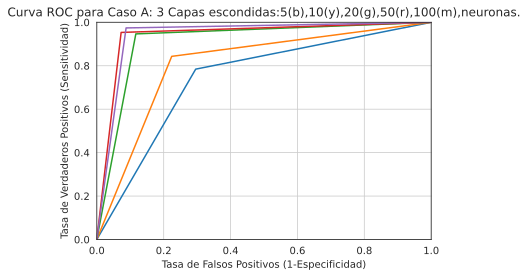

In [200]:
# # # # Implemente un ciclo FOR para entrenar cada una de las configuraciones solicitadas # # # #
# Caso C: 3 capas escondidas  ×  {5, 10, 20, 50, 100} neuronas.

from sklearn.model_selection import train_test_split

X_valid, X_test2, y_valid, y_test2 = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

neuronas=[5,10,20,50,100]
#neurona=0

for i in neuronas:
    model = MLPClassifier( hidden_layer_sizes=[i,i,i], activation='relu') ##
    model.fit(X_valid,y_valid) # Acá se entrena con los datos de validación #
    y_predict = model.predict(X_test2) #Acá y_predict se evalua con los datos test_2#
    print (i)
    print(f'Precisión con {round(i,5)} neuronas y tres capas escondidas {round(accuracy_score(y_test2, y_predict),5)}')
    print(pd.DataFrame(confusion_matrix(y_test2,y_predict)))
     # Grafica ROC
    fpr, tpr, thresholds = roc_curve(y_test2,y_predict)
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Curva ROC para Caso A: 3 Capas escondidas:5(b),10(y),20(g),50(r),100(m),neuronas.')
    plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
    plt.grid(True)




5
Precisión con 5 neuronas y cuatro capas escondidas 0.75263
      0     1
0  2589  1120
1   714  2991
10
Precisión con 10 neuronas y cuatro capas escondidas 0.84017
      0     1
0  2921   788
1   397  3308
20
Precisión con 20 neuronas y cuatro capas escondidas 0.91813
      0     1
0  3254   455
1   152  3553
50
Precisión con 50 neuronas y cuatro capas escondidas 0.93323
      0     1
0  3266   443
1    52  3653
100
Precisión con 100 neuronas y cuatro capas escondidas 0.94807
      0     1
0  3409   300
1    85  3620


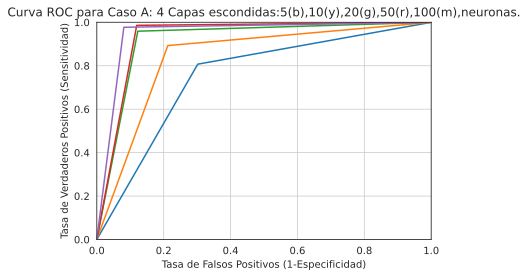

In [201]:
## Provemos con más capas porque esta bajando la precisión, provemos con 4 y con 5 capas
## 4 Capas escondidas.
from sklearn.model_selection import train_test_split

X_valid, X_test2, y_valid, y_test2 = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

neuronas=[5,10,20,50,100]
#neurona=0

for i in neuronas:
    model = MLPClassifier( hidden_layer_sizes=[i,i,i,i], activation='relu') ##
    model.fit(X_valid,y_valid) # Acá se entrena con los datos de validación #
    y_predict = model.predict(X_test2) #Acá y_predict se evalua con los datos test_2#
    print (i)
    print(f'Precisión con {round(i,5)} neuronas y cuatro capas escondidas {round(accuracy_score(y_test2, y_predict),5)}')
    print(pd.DataFrame(confusion_matrix(y_test2,y_predict)))
     # Grafica ROC
    fpr, tpr, thresholds = roc_curve(y_test2,y_predict)
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Curva ROC para Caso A: 4 Capas escondidas:5(b),10(y),20(g),50(r),100(m),neuronas.')
    plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
    plt.grid(True)
 


5
Precisión con 5 neuronas y cinco capas escondidas 0.68708
      0     1
0  3145   564
1  1756  1949
10
Precisión con 10 neuronas y cinco capas escondidas 0.85082
      0     1
0  3019   690
1   416  3289
20
Precisión con 20 neuronas y cinco capas escondidas 0.92015
      0     1
0  3303   406
1   186  3519
50
Precisión con 50 neuronas y cinco capas escondidas 0.93998
      0     1
0  3452   257
1   188  3517
100
Precisión con 100 neuronas y cinco capas escondidas 0.94443
      0     1
0  3356   353
1    59  3646


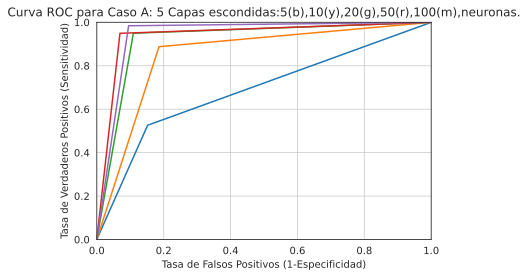

In [202]:
## 5 Capas escondidas.
from sklearn.model_selection import train_test_split

X_valid, X_test2, y_valid, y_test2 = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

neuronas=[5,10,20,50,100]
#neurona=0

for i in neuronas:
    model = MLPClassifier( hidden_layer_sizes=[i,i,i,i,i], activation='relu') ##
    model.fit(X_valid,y_valid) # Acá se entrena con los datos de validación #
    y_predict = model.predict(X_test2) #Acá y_predict se evalua con los datos test_2#
    print (i)
    print(f'Precisión con {round(i,5)} neuronas y cinco capas escondidas {round(accuracy_score(y_test2, y_predict),5)}')
    print(pd.DataFrame(confusion_matrix(y_test2,y_predict)))
     # Grafica ROC
    fpr, tpr, thresholds = roc_curve(y_test2,y_predict)
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Curva ROC para Caso A: 5 Capas escondidas:5(b),10(y),20(g),50(r),100(m),neuronas.')
    plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
    plt.grid(True) 


5
Precisión con 5 neuronas y diez capas escondidas 0.7266
      0     1
0  2626  1083
1   944  2761
10
Precisión con 10 neuronas y diez capas escondidas 0.79161
      0     1
0  3146   563
1   982  2723
20
Precisión con 20 neuronas y diez capas escondidas 0.90477
      0     1
0  3180   529
1   177  3528
50
Precisión con 50 neuronas y diez capas escondidas 0.93674
      0     1
0  3475   234
1   235  3470
100
Precisión con 100 neuronas y diez capas escondidas 0.94227
      0     1
0  3341   368
1    60  3645


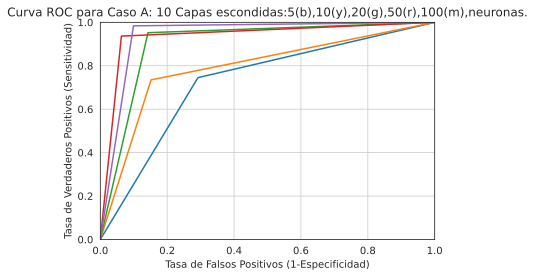

In [203]:
# La última prueba con 10 capas escondidas

from sklearn.model_selection import train_test_split

X_valid, X_test2, y_valid, y_test2 = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

neuronas=[5,10,20,50,100]
#neurona=0

for i in neuronas:
    model = MLPClassifier( hidden_layer_sizes=[i,i,i,i,i,i,i,i,i,i], activation='relu') ##
    model.fit(X_valid,y_valid) # Acá se entrena con los datos de validación #
    y_predict = model.predict(X_test2) #Acá y_predict se evalua con los datos test_2#
    print (i)
    print(f'Precisión con {round(i,5)} neuronas y diez capas escondidas {round(accuracy_score(y_test2, y_predict),5)}')
    print(pd.DataFrame(confusion_matrix(y_test2,y_predict)))
     # Grafica ROC
    fpr, tpr, thresholds = roc_curve(y_test2,y_predict)
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Curva ROC para Caso A: 10 Capas escondidas:5(b),10(y),20(g),50(r),100(m),neuronas.')
    plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
    plt.grid(True)


### Gráficas Evaluativas (Adjuntas en los resultados de la parte 3)

## Análisis y conclusiones

El Aprendizaje tiene varias etapas, en las  dos tareas anteriores de machine se realizó el preprocesamiento de datos, modelo con datos de entrenamiento y por último se evaluó el modelo con datos de prueba.

En la tarea 3 el aprendizaje pasa por varias etapas:
1. Se dividen los datos: entrenamiento, prueba: que se dividirán después en 50% de validación y 50% de prueba.

2. Modelo

3. Adecuación/ preprocesamiento de datos (codificación, desbalanceo de datos)

4. Entrenamiento 
   
   * 4.1. Error   
   * 4.2 Modelos de distinto tamaño (Caso A, Caso B, Caso C) , complejidad    (Baseline, red neuronal.) Datos de entrenamiento. Parte 2 de la tarea.
         

      *   4.2.1 Optimizar la función error con datos de entrenamiento.
      *   4.2.2. **PARTE 3** Evaluar con datos de validación: se realiza esta etapa de entrenamiento probando en datos que no ha visto el modelo, los datos de validación provien de los datos de prueba. Se hace esta etapa con datos de validación para evitar el sobreajuste a los datos, sino se hace este procedimeinto el aprendizaje no sirve para nada. Por lo cuál esta etapa indispensable. 

       *  4.3 Se selecciona el modelo con menos error, entrenado con datos de validación. 


5.Evaluación con los datos de prueba y el resultado final fue el siguiente: 

El mejor modelo es el de  4 capas escondidas y 100 neuronas: Precisión con 100 neuronas y cuatro capas escondidas: 0.94686, junto con su matriz de confución:  TN=3411,  FP= 298,  FN=  96  TP= 3609
Se entrenó con más capas para mirar el comportamiento hasta 10 capas, pero como se mencionó anteriormente el mejor resultado fue de 4 capas de 100 neuronas.

## Análisis de las gráficas ROC:

* Con más neuronas se mejora la curva ROC, confirma la teoría que con mas neuronas el error disminuye.

* Datos para resaltar:
1.   En 10 capas esconditas; de 50 neuronas y 100 neuronas, es exactamente la misma curva ROC, entonces es necesario solo de 50 neuronas para bajar la carga computacional.
2.   Aquí podemos ver que no es necesario muchas capas escondidas porque se llegó al mejor resultado en 4 capas.

3. La pendiente de subida la de 100n, 50n, y 20n, son muy cercanas lo cuál se puede inferir que de 20 neuronas también se logran buenos resultados este efecto se vió en todas las diferentes valores de capas que se realizaron.



Opinión personal y futuras direcciones: fué una tarea con una metodología exceente porque me permitió aclarar varias puntos claves mientran se desarrollaba cada item. 
También debo mencionar las gracias al monitor Alejandro porque siempre está dispuesto  a colaborar caulquier día sin importar si es fin de semana. Muchas gracias. Alba Pico. Código 201421875





# Bono (2 puntos)

Implemente el mejor modelo de red neuronal. Desarrolle el método de **_backpropagation_** para realizar el entrenamiento de la red sin utilizar ningún tipo de librería que tenga funciones prestablecidas con objetivos de apoyo en el tema de Machine Learning. Puede utilizar Numpy, Pandas, etc. NO puede utilizar: SciKit-Learn, Tensorflow/Keras, PyTorch, etc.

El bono debe estar COMPLETO y se debe observar una curva de aprendizaje a través de las iteraciones que permita obtener resultados aceptables con respecto a la red definida a partir de SciKit-Learn. De lo contrario, no se tomará como válido.

In [ ]:
# # # # Implemente el método de backpropagation para la arquitectura seleccionada # # # #
#
#
#
#
#
#
# ...